# 迁移学习微调训练图像分类模型

在自己的图像分类数据集上，使用ImageNet预训练图像分类模型初始化，改动分类层，迁移学习微调训练

同济子豪兄：https://space.bilibili.com/1900783

[代码运行云GPU环境](https://featurize.cn/?s=d7ce99f842414bfcaea5662a97581bd1)：GPU RTX 3060、CUDA v11.2

## 设置matplotlib中文字体

In [3]:
# windows操作系统
plt.rcParams['font.sans-serif']=['SimHei']  # 用来正常显示中文标签 
plt.rcParams['axes.unicode_minus']=False  # 用来正常显示负号

In [17]:
# Mac操作系统，参考 https://www.ngui.cc/51cto/show-727683.html
# 下载 simhei.ttf 字体文件
# !wget https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20220716-mmclassification/dataset/SimHei.ttf

In [1]:
# # Linux操作系统，例如 云GPU平台：https://featurize.cn/?s=d7ce99f842414bfcaea5662a97581bd1
# # 如果遇到 SSL 相关报错，重新运行本代码块即可
# !wget https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20220716-mmclassification/dataset/SimHei.ttf -O /environment/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/SimHei.ttf
# !rm -rf /home/featurize/.cache/matplotlib

# import matplotlib
# import matplotlib.pyplot as plt
# matplotlib.rc("font",family='SimHei') # 中文字体
# plt.rcParams['axes.unicode_minus']=False  # 用来正常显示负号

--2022-08-18 08:31:41--  https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20220716-mmclassification/dataset/SimHei.ttf
Connecting to 172.16.0.13:5848... connected.
Proxy request sent, awaiting response... 200 OK
Length: 10050868 (9.6M) [application/x-font-ttf]
Saving to: ‘/environment/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/SimHei.ttf’

/environment/minico 100%[===================>]   9.58M  21.4MB/s    in 0.4s    

2022-08-18 08:31:42 (21.4 MB/s) - ‘/environment/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/SimHei.ttf’ saved [10050868/10050868]



## 导入工具包

In [2]:
import time
import os

import numpy as np
from tqdm import tqdm

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

# 忽略烦人的红色提示
import warnings
warnings.filterwarnings("ignore")

## 获取计算硬件

In [4]:
# 有 GPU 就用 GPU，没有就用 CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device', device)

device cpu


## 图像预处理

In [5]:
from torchvision import transforms

# 训练集图像预处理：缩放裁剪、图像增强、转 Tensor、归一化
train_transform = transforms.Compose([transforms.RandomResizedCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                     ])

# 测试集图像预处理-RCTN：缩放、裁剪、转 Tensor、归一化
test_transform = transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(
                                         mean=[0.485, 0.456, 0.406], 
                                         std=[0.229, 0.224, 0.225])
                                    ])

## 载入图像分类数据集

In [6]:
# 数据集文件夹路径
dataset_dir = 'fruit81_split'

In [7]:
train_path = os.path.join(dataset_dir, 'train')
test_path = os.path.join(dataset_dir, 'val')
print('训练集路径', train_path)
print('测试集路径', test_path)

训练集路径 fruit81_split\train
测试集路径 fruit81_split\val


In [8]:
from torchvision import datasets

# 载入训练集
train_dataset = datasets.ImageFolder(train_path, train_transform)

# 载入测试集
test_dataset = datasets.ImageFolder(test_path, test_transform)

In [9]:
print('训练集图像数量', len(train_dataset))
print('类别个数', len(train_dataset.classes))
print('各类别名称', train_dataset.classes)

训练集图像数量 11579
类别个数 81
各类别名称 ['人参果', '佛手瓜', '哈密瓜', '圣女果', '山楂', '山竹', '无花果', '木瓜', '李子', '杏', '杨桃', '杨梅', '枇杷', '枣', '柚子', '柠檬', '柿子', '树莓', '桂圆', '桑葚', '梨', '椰子', '榴莲', '樱桃', '橘子', '毛丹', '水蜜桃', '沃柑', '沙果', '沙棘', '油桃', '牛油果', '猕猴桃', '甘蔗', '甜瓜-伊丽莎白', '甜瓜-白', '甜瓜-绿', '甜瓜-金', '番石榴-百', '番石榴-红', '白兰瓜', '白心火龙果', '白萝卜', '百香果', '石榴', '砂糖橘', '粑粑柑', '红心火龙果', '红苹果', '羊奶果', '羊角蜜', '胡萝卜', '脐橙', '腰果', '芒果', '芦柑', '草莓', '荔枝', '莲雾', '菠萝', '菠萝莓', '菠萝蜜', '葡萄-白', '葡萄-红', '蓝莓', '蛇皮果', '蟠桃', '血橙', '西柚', '西梅', '西瓜', '西红柿', '车厘子', '酸角', '金桔', '青柠', '青苹果', '香橼', '香蕉', '黄桃', '黑莓']


In [10]:
print('测试集图像数量', len(test_dataset))
print('类别个数', len(test_dataset.classes))
print('各类别名称', test_dataset.classes)

测试集图像数量 2854
类别个数 81
各类别名称 ['人参果', '佛手瓜', '哈密瓜', '圣女果', '山楂', '山竹', '无花果', '木瓜', '李子', '杏', '杨桃', '杨梅', '枇杷', '枣', '柚子', '柠檬', '柿子', '树莓', '桂圆', '桑葚', '梨', '椰子', '榴莲', '樱桃', '橘子', '毛丹', '水蜜桃', '沃柑', '沙果', '沙棘', '油桃', '牛油果', '猕猴桃', '甘蔗', '甜瓜-伊丽莎白', '甜瓜-白', '甜瓜-绿', '甜瓜-金', '番石榴-百', '番石榴-红', '白兰瓜', '白心火龙果', '白萝卜', '百香果', '石榴', '砂糖橘', '粑粑柑', '红心火龙果', '红苹果', '羊奶果', '羊角蜜', '胡萝卜', '脐橙', '腰果', '芒果', '芦柑', '草莓', '荔枝', '莲雾', '菠萝', '菠萝莓', '菠萝蜜', '葡萄-白', '葡萄-红', '蓝莓', '蛇皮果', '蟠桃', '血橙', '西柚', '西梅', '西瓜', '西红柿', '车厘子', '酸角', '金桔', '青柠', '青苹果', '香橼', '香蕉', '黄桃', '黑莓']


## 类别和索引号 一一对应

In [11]:
# 各类别名称
class_names = train_dataset.classes
n_class = len(class_names)

In [12]:
class_names

['人参果',
 '佛手瓜',
 '哈密瓜',
 '圣女果',
 '山楂',
 '山竹',
 '无花果',
 '木瓜',
 '李子',
 '杏',
 '杨桃',
 '杨梅',
 '枇杷',
 '枣',
 '柚子',
 '柠檬',
 '柿子',
 '树莓',
 '桂圆',
 '桑葚',
 '梨',
 '椰子',
 '榴莲',
 '樱桃',
 '橘子',
 '毛丹',
 '水蜜桃',
 '沃柑',
 '沙果',
 '沙棘',
 '油桃',
 '牛油果',
 '猕猴桃',
 '甘蔗',
 '甜瓜-伊丽莎白',
 '甜瓜-白',
 '甜瓜-绿',
 '甜瓜-金',
 '番石榴-百',
 '番石榴-红',
 '白兰瓜',
 '白心火龙果',
 '白萝卜',
 '百香果',
 '石榴',
 '砂糖橘',
 '粑粑柑',
 '红心火龙果',
 '红苹果',
 '羊奶果',
 '羊角蜜',
 '胡萝卜',
 '脐橙',
 '腰果',
 '芒果',
 '芦柑',
 '草莓',
 '荔枝',
 '莲雾',
 '菠萝',
 '菠萝莓',
 '菠萝蜜',
 '葡萄-白',
 '葡萄-红',
 '蓝莓',
 '蛇皮果',
 '蟠桃',
 '血橙',
 '西柚',
 '西梅',
 '西瓜',
 '西红柿',
 '车厘子',
 '酸角',
 '金桔',
 '青柠',
 '青苹果',
 '香橼',
 '香蕉',
 '黄桃',
 '黑莓']

In [13]:
# 映射关系：类别 到 索引号
train_dataset.class_to_idx

{'人参果': 0,
 '佛手瓜': 1,
 '哈密瓜': 2,
 '圣女果': 3,
 '山楂': 4,
 '山竹': 5,
 '无花果': 6,
 '木瓜': 7,
 '李子': 8,
 '杏': 9,
 '杨桃': 10,
 '杨梅': 11,
 '枇杷': 12,
 '枣': 13,
 '柚子': 14,
 '柠檬': 15,
 '柿子': 16,
 '树莓': 17,
 '桂圆': 18,
 '桑葚': 19,
 '梨': 20,
 '椰子': 21,
 '榴莲': 22,
 '樱桃': 23,
 '橘子': 24,
 '毛丹': 25,
 '水蜜桃': 26,
 '沃柑': 27,
 '沙果': 28,
 '沙棘': 29,
 '油桃': 30,
 '牛油果': 31,
 '猕猴桃': 32,
 '甘蔗': 33,
 '甜瓜-伊丽莎白': 34,
 '甜瓜-白': 35,
 '甜瓜-绿': 36,
 '甜瓜-金': 37,
 '番石榴-百': 38,
 '番石榴-红': 39,
 '白兰瓜': 40,
 '白心火龙果': 41,
 '白萝卜': 42,
 '百香果': 43,
 '石榴': 44,
 '砂糖橘': 45,
 '粑粑柑': 46,
 '红心火龙果': 47,
 '红苹果': 48,
 '羊奶果': 49,
 '羊角蜜': 50,
 '胡萝卜': 51,
 '脐橙': 52,
 '腰果': 53,
 '芒果': 54,
 '芦柑': 55,
 '草莓': 56,
 '荔枝': 57,
 '莲雾': 58,
 '菠萝': 59,
 '菠萝莓': 60,
 '菠萝蜜': 61,
 '葡萄-白': 62,
 '葡萄-红': 63,
 '蓝莓': 64,
 '蛇皮果': 65,
 '蟠桃': 66,
 '血橙': 67,
 '西柚': 68,
 '西梅': 69,
 '西瓜': 70,
 '西红柿': 71,
 '车厘子': 72,
 '酸角': 73,
 '金桔': 74,
 '青柠': 75,
 '青苹果': 76,
 '香橼': 77,
 '香蕉': 78,
 '黄桃': 79,
 '黑莓': 80}

In [14]:
# 映射关系：索引号 到 类别
idx_to_labels = {y:x for x,y in train_dataset.class_to_idx.items()}

In [15]:
idx_to_labels

{0: '人参果',
 1: '佛手瓜',
 2: '哈密瓜',
 3: '圣女果',
 4: '山楂',
 5: '山竹',
 6: '无花果',
 7: '木瓜',
 8: '李子',
 9: '杏',
 10: '杨桃',
 11: '杨梅',
 12: '枇杷',
 13: '枣',
 14: '柚子',
 15: '柠檬',
 16: '柿子',
 17: '树莓',
 18: '桂圆',
 19: '桑葚',
 20: '梨',
 21: '椰子',
 22: '榴莲',
 23: '樱桃',
 24: '橘子',
 25: '毛丹',
 26: '水蜜桃',
 27: '沃柑',
 28: '沙果',
 29: '沙棘',
 30: '油桃',
 31: '牛油果',
 32: '猕猴桃',
 33: '甘蔗',
 34: '甜瓜-伊丽莎白',
 35: '甜瓜-白',
 36: '甜瓜-绿',
 37: '甜瓜-金',
 38: '番石榴-百',
 39: '番石榴-红',
 40: '白兰瓜',
 41: '白心火龙果',
 42: '白萝卜',
 43: '百香果',
 44: '石榴',
 45: '砂糖橘',
 46: '粑粑柑',
 47: '红心火龙果',
 48: '红苹果',
 49: '羊奶果',
 50: '羊角蜜',
 51: '胡萝卜',
 52: '脐橙',
 53: '腰果',
 54: '芒果',
 55: '芦柑',
 56: '草莓',
 57: '荔枝',
 58: '莲雾',
 59: '菠萝',
 60: '菠萝莓',
 61: '菠萝蜜',
 62: '葡萄-白',
 63: '葡萄-红',
 64: '蓝莓',
 65: '蛇皮果',
 66: '蟠桃',
 67: '血橙',
 68: '西柚',
 69: '西梅',
 70: '西瓜',
 71: '西红柿',
 72: '车厘子',
 73: '酸角',
 74: '金桔',
 75: '青柠',
 76: '青苹果',
 77: '香橼',
 78: '香蕉',
 79: '黄桃',
 80: '黑莓'}

In [16]:
# 保存为本地的 npy 文件
np.save('idx_to_labels.npy', idx_to_labels)
np.save('labels_to_idx.npy', train_dataset.class_to_idx)

## 定义数据加载器DataLoader

In [17]:
from torch.utils.data import DataLoader

In [18]:
BATCH_SIZE = 32

# 训练集的数据加载器
train_loader = DataLoader(train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=4
                         )

# 测试集的数据加载器
test_loader = DataLoader(test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=4
                        )

## 查看一个batch的图像和标注

In [19]:
# DataLoader 是 python生成器，每次调用返回一个 batch 的数据
images, labels = next(iter(train_loader))

In [20]:
images.shape

torch.Size([32, 3, 224, 224])

In [21]:
labels

tensor([40, 38, 61, 71, 16, 78, 27, 58, 43, 71, 50, 25, 43, 27, 16, 26, 18, 22,
        12, 23, 67,  1, 42, 76, 54, 59, 27, 71, 63, 29, 25, 67])

## 可视化一个batch的图像和标注

In [22]:
# 将数据集中的Tensor张量转为numpy的array数据类型
images = images.numpy()

In [23]:
images[5].shape

(3, 224, 224)

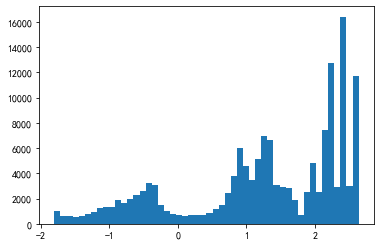

In [24]:
plt.hist(images[5].flatten(), bins=50)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'label:61')

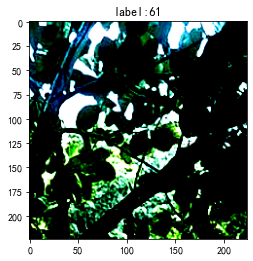

In [25]:
# batch 中经过预处理的图像
idx = 2
plt.imshow(images[idx].transpose((1,2,0))) # 转为(224, 224, 3)
plt.title('label:'+str(labels[idx].item()))

In [26]:
label = labels[idx].item()

In [27]:
label

61

In [28]:
pred_classname = idx_to_labels[label]

In [29]:
pred_classname

'菠萝蜜'

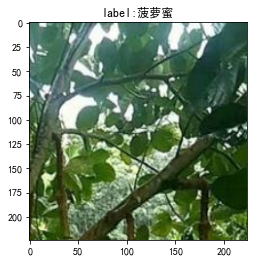

In [30]:
# 原始图像
idx = 2
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.imshow(np.clip(images[idx].transpose((1,2,0)) * std + mean, 0, 1))
plt.title('label:'+ pred_classname)
plt.show()

## 导入训练需使用的工具包

In [33]:
from torchvision import models
import torch.optim as optim

## 选择迁移学习训练方式

斯坦福CS231N【迁移学习】中文精讲：https://www.bilibili.com/video/BV1K7411W7So

斯坦福CS231N【迁移学习】官方笔记：https://cs231n.github.io/transfer-learning/

### 选择一：只微调训练模型最后一层（全连接分类层）

In [34]:
model = models.resnet18(pretrained=True) # 载入预训练模型

# 修改全连接层，使得全连接层的输出与当前数据集类别数对应
# 新建的层默认 requires_grad=True
model.fc = nn.Linear(model.fc.in_features, n_class)

In [35]:
model.fc

Linear(in_features=512, out_features=81, bias=True)

In [36]:
# 只微调训练最后一层全连接层的参数，其它层冻结
optimizer = optim.Adam(model.fc.parameters())

### 选择二：微调训练所有层

In [37]:
# model = models.resnet18(pretrained=True) # 载入预训练模型

# model.fc = nn.Linear(model.fc.in_features, n_class)

# optimizer = optim.Adam(model.parameters())

### 选择三：随机初始化模型全部权重，从头训练所有层

In [38]:
# model = models.resnet18(pretrained=False) # 只载入模型结构，不载入预训练权重参数

# model.fc = nn.Linear(model.fc.in_features, n_class)

# optimizer = optim.Adam(model.parameters())

## 训练配置

In [37]:
model = model.to(device)

# 交叉熵损失函数
criterion = nn.CrossEntropyLoss() 

# 训练轮次 Epoch
EPOCHS = 20

## 模拟一个batch的训练

In [38]:
# 获得一个 batch 的数据和标注
images, labels = next(iter(train_loader))
images = images.to(device)
labels = labels.to(device)

In [39]:
# 输入模型，执行前向预测
outputs = model(images)

In [40]:
# 获得当前 batch 所有图像的预测类别 logit 分数
outputs.shape

torch.Size([32, 81])

In [41]:
# 由 logit，计算当前 batch 中，每个样本的平均交叉熵损失函数值
loss = criterion(outputs, labels)

In [42]:
# 反向传播“三部曲”
optimizer.zero_grad() # 清除梯度
loss.backward() # 反向传播
optimizer.step() # 优化更新

In [43]:
# 获得当前 batch 所有图像的预测类别
_, preds = torch.max(outputs, 1)

In [44]:
preds

tensor([ 5, 63, 71, 60, 33, 15,  5, 71, 15, 33, 71, 71, 74, 71, 71, 60, 53,  5,
        71, 33, 15, 71, 66, 71,  5, 71, 56, 33, 78, 71, 60, 71])

In [45]:
labels

tensor([ 8, 41, 13, 80,  6, 13, 75, 54, 42,  7, 57,  3, 10, 66, 76, 23, 70, 52,
        72, 54, 20,  5,  5, 48,  7, 52, 16, 19, 21,  6, 16, 49])

## 运行完整训练

In [46]:
# 遍历每个 EPOCH
for epoch in tqdm(range(EPOCHS)):

    model.train()

    for images, labels in train_loader:  # 获得一个 batch 的数据和标注
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels) # 计算当前 batch 中，每个样本的平均交叉熵损失函数值
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

  0%|                                                                                           | 0/10 [01:26<?, ?it/s]


KeyboardInterrupt: 

## 在测试集上初步测试

In [52]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in tqdm(test_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum()

    print('测试集上的准确率为 {:.3f} %'.format(100 * correct / total))

100%|██████████| 34/34 [00:02<00:00, 11.58it/s]

测试集上的准确率为 85.913 %


## 保存模型

In [53]:
torch.save(model, 'checkpoints/fruit30_pytorch_20220814.pth')

## 参考文档

https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

https://www.bilibili.com/video/BV1qe4y1D7zD

https://www.bilibili.com/video/BV14J411X7Bb

https://www.bilibili.com/video/BV1w4411u7ay